# Shifted Beta Geometric model with population data

In this notebook we replicate the main results and figures from 

Fader, P. S., & Hardie, B. G. (2007). How to project customer retention. Journal of Interactive Marketing, 21(1), 76-90. https://journals.sagepub.com/doi/pdf/10.1002/dir.20074

The authors describe the Shifted Beta Geometric (sBG) model for customer behavior in a discrete contractual setting. It assumes that:
  * At the end of each period, a customer has a probability `theta` of renewing the contract
    and `1-theta` of cancelling
  * The probability `theta` does not change over time for a given customer
  * The probability `theta` varies across customers according to a Beta prior distribution
    with hyperparameters `alpha` and `beta`.

In [1]:
import pytensor

#set flag to hotfix open c++ errors
pytensor.config.cxx = '/usr/bin/clang++'

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from pymc_marketing import clv
import pymc as pm
from pymc_extras.prior import Prior

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:

dataset = pd.read_csv("https://raw.githubusercontent.com/ColtAllen/pymc-marketing/refs/heads/clv-sbg-model/data/sbg_reg_hi_cohorts.csv")
#dataset = pd.read_csv("https://raw.githubusercontent.com/ColtAllen/pymc-marketing/refs/heads/clv-sbg-model/data/sbg_case1_cohorts.csv")

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  2000 non-null   int64 
 1   recency      2000 non-null   int64 
 2   T            2000 non-null   int64 
 3   cohorts      2000 non-null   object
dtypes: int64(3), object(1)
memory usage: 62.6+ KB


### Mean and Polarization Parametrization Experimentation

In [11]:
cohort_idx = pd.Categorical(dataset["cohorts"], categories=["regular","highend"]).codes  # shape (N,)

coords = {
    "customer_id": dataset["customer_id"],
    "cohorts": ["regular","highend"],
}
with pm.Model(coords=coords) as model:
    
    # alpha = pm.HalfFlat("alpha",dims="cohorts")
    # beta = pm.HalfFlat("beta",dims="cohorts")
    c = pm.HalfFlat("c",dims="cohorts")

    phi = pm.Uniform("phi", lower=0, upper=1,dims="cohorts")
    kappa = pm.Pareto("kappa", alpha=1,m=1,dims="cohorts")

    alpha = pm.Deterministic("alpha", phi * kappa,dims="cohorts")
    beta = pm.Deterministic("beta", (1 - phi) * kappa,dims="cohorts")
    #theta = pm.Beta("dropout",alpha=alpha,beta=beta)

    # cannot use halfflat prior here due to zero initialization
    # mean_dropout = pm.Beta("dropout", alpha=1,beta=1, dims="cohorts")
    # polarization = pm.Beta("polarization", alpha=1,beta=1, dims="cohorts")

    # alpha = pm.Deterministic("alpha", mean_dropout * (1/polarization - 1),dims="cohorts")
    # beta = pm.Deterministic("beta", (1-mean_dropout) * (1/polarization - 1),dims="cohorts")
    
    sbg = clv.distributions.ShiftedBetaGeometric.dist(
        alpha[cohort_idx],
        beta[cohort_idx],
        c[cohort_idx],
    )

    pm.Censored(
        "churn_censored",
        sbg,
        lower=None,
        upper=dataset["T"],
        observed=dataset["recency"],
        dims="customer_id",
    )

    idata = pm.sample()#nuts_sampler="nutpie")
    #idata = pm.find_MAP()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, phi, kappa]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
There were 137 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'dropout'}>,
        <Axes: title={'center': 'dropout'}>],
       [<Axes: title={'center': 'polarization'}>,
        <Axes: title={'center': 'polarization'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

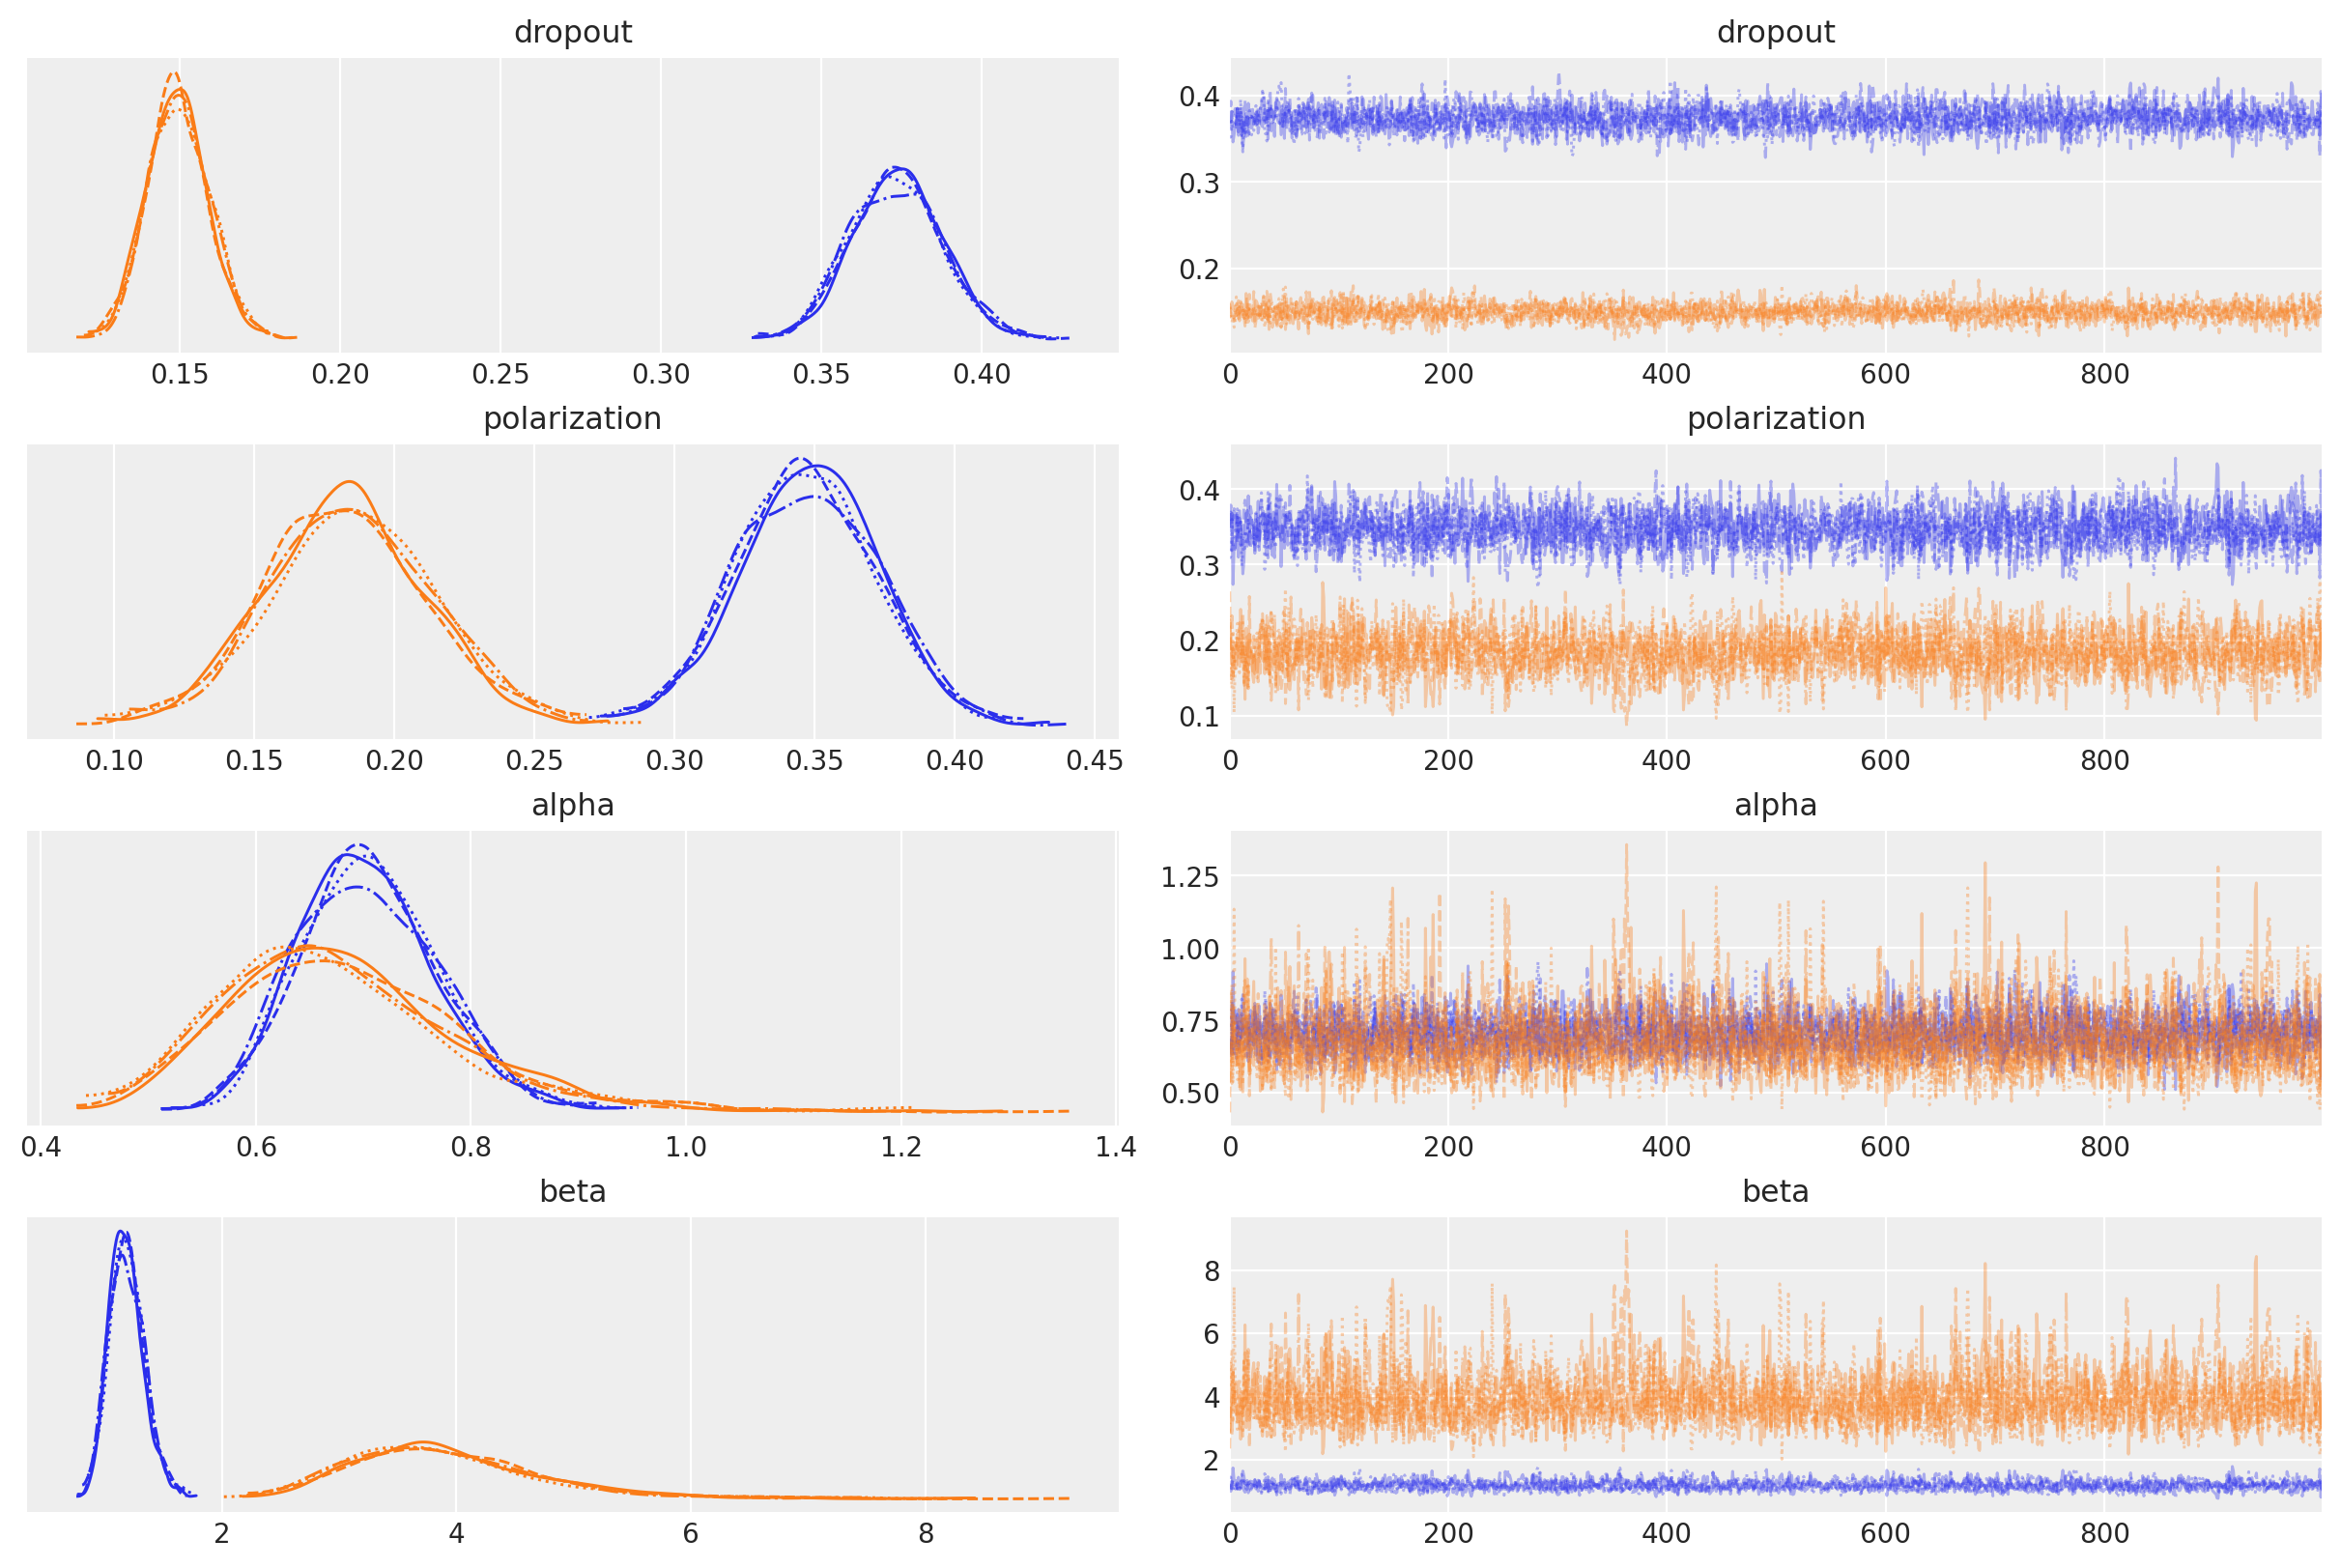

In [68]:
az.plot_trace(idata)#,var_names=["alpha", "beta", "dropout"])

In [69]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [70]:
az.summary(idata.posterior)

# pooling
# alpha[regular]	0.701	
# alpha[highend]	0.669	
# beta[regular]	1.179	
# beta[highend]	3.811

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
dropout[regular],0.374,0.014,0.347,0.400,0.000,0.000,2578.0,2917.0,1.0
dropout[highend],0.150,0.010,0.132,0.168,0.000,0.000,2079.0,2545.0,1.0
polarization[regular],0.347,0.025,0.298,0.392,0.000,0.000,2514.0,2751.0,1.0
polarization[highend],0.184,0.029,0.125,0.237,0.001,0.000,1996.0,2258.0,1.0
alpha[regular],0.706,0.065,0.583,0.822,0.001,0.001,3130.0,3142.0,1.0
alpha[highend],0.681,0.114,0.489,0.887,0.002,0.003,2329.0,2374.0,1.0
beta[regular],1.189,0.150,0.903,1.465,0.003,0.002,2369.0,2534.0,1.0
beta[highend],3.918,0.862,2.448,5.461,0.021,0.022,1969.0,2244.0,1.0


In [ ]:
# MLE estimates from the paper
ref_val = {
    "highend": [0.688, 3.806],
    "regular": [0.704, 1.182],
}

## Fitting the sBG models for high end and regular user cohorts

In [4]:
sbg = clv.ShiftedBetaGeoModel(
    data=dataset,
    model_config = {
        "alpha": Prior("HalfFlat",dims="cohorts"),
        "beta": Prior("HalfFlat",dims="cohorts"),
    }
)
sbg.build_model()
sbg.fit(fit_method='map')

Output()

Inference data with groups:
	> posterior
	> observed_data
	> fit_data

## Contrasting posterior inferences with the repo MLE estimates

In [47]:
# MLE estimates from the paper
ref_val = {
    "highend": [0.688, 3.806],
    "regular": [0.704, 1.182],
}
sbg.fit_summary()
#az.plot_trace(sbg.idata,var_names=["alpha", "beta"])

AttributeError: 'TensorVariable' object has no attribute 'fit_summary'

# Predictive Methods

In [71]:
# predictions can only be ran on active customers
active_df = dataset[dataset["recency"] == dataset["T"]].copy()

In [72]:
sbg.expected_probability_alive(active_df,future_t=0).mean(("chain","draw")).to_pandas()

customer_id
5610     0.366455
5611     0.366455
5612     0.366455
5613     0.366455
5614     0.366455
           ...   
49996    0.500000
49997    0.500000
49998    0.500000
49999    0.500000
50000    0.500000
Length: 34178, dtype: float64

In [73]:
sbg.expected_retention_rate(active_df,future_t=0).mean(("chain","draw")).to_pandas()

customer_id
5610     0.834659
5611     0.834659
5612     0.834659
5613     0.834659
5614     0.834659
           ...   
49996    0.500000
49997    0.500000
49998    0.500000
49999    0.500000
50000    0.500000
Length: 34178, dtype: float64

# Additional Predictive Methods

Below methods are described in https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_contractual_mksc_10.pdf, and could be good candidates for a future PR.

### Simulate Data from Paper

In [61]:
import numpy as np
import pandas as pd

# Cohort table from the markdown (empty cells omitted)
# only need the params for unit testing
# alpha 3.80, beta = 15.20
cohort_counts = {
    2001: {2001: 10000, 2002: 8000, 2003: 6480, 2004: 5307, 2005: 4391},
    2002: {2002: 10000, 2003: 8000, 2004: 6480, 2005: 5307},
    2003: {2003: 10000, 2004: 8000, 2005: 6480},
    2004: {2004: 10000, 2005: 8000},
    2005: {2005: 10000},
}

# alpha=0.067, beta=0.267
case2 = {
    2003: {2003: 10000, 2004: 8000, 2005: 7600, 2006: 7383, 2007: 7235},
    2004: {2004: 10000, 2005: 8000, 2006: 7600, 2007: 7383},
    2005: {2005: 10000, 2006: 8000, 2007: 7600},
    2006: {2006: 10000, 2007: 8000},
    2007: {2007: 10000},
}
# (Bottom totals row is intentionally ignored)

rows = []
for cohort, year_counts in cohort_counts.items():
    years_sorted = sorted(year_counts)
    ages = [y - cohort for y in years_sorted]
    S = [year_counts[y] for y in years_sorted]  # survivors per age
    last_t = ages[-1]  # observation window for this cohort (right-censoring time T)

    # Churn in interval t -> t+1 (event observed at t)
    for t in range(len(S) - 1):
        count = S[t] - S[t + 1]
        if count > 0:
            rows.append({"cohort": cohort, "t_churn": t, "T": last_t, "count": count})

    # Right-censored at last observed age (still active)
    if S[-1] > 0:
        rows.append({"cohort": cohort, "t_churn": last_t, "T": last_t, "count": S[-1]})

counts_df = pd.DataFrame(rows)

# Expand to one row per customer
t_churn_array = np.repeat(counts_df["t_churn"].to_numpy(), counts_df["count"].to_numpy())
T_array = np.repeat(counts_df["T"].to_numpy(), counts_df["count"].to_numpy())
cohort_array = np.repeat(counts_df["cohort"].to_numpy(), counts_df["count"].to_numpy())
customer_id = np.arange(t_churn_array.size)

df = pd.DataFrame(
    {
        "customer_id": customer_id + 1,
        "recency": t_churn_array + 1,
        "T": T_array + 1,
        "cohort": cohort_array,
    }
).astype({"customer_id": int, "t_churn": int, "T": int, "cohort": str})

#df.to_csv("sbg_cohorts.csv",index=False)

##### Expected Retention Elasticity

In [74]:
    def expected_retention_elasticity(
        self,
        data: pd.DataFrame | None = None,
        *,
        discount_rate: float = 0.0,
    ) -> xarray.DataArray:
        """Compute expected retention elasticity.

        Adapted from equation (8) in [1]_.

        References
        ----------
        .. [1] Fader, P. S., & Hardie, B. G. (2010). Customer-Base Valuation in a Contractual Setting:
               The Perils of Ignoring Heterogeneity. Marketing Science, 29(1), 85-93.
               https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_contractual_mksc_10.pdf
        """
        if data is None:
            data = self.data

        dataset = self._extract_predictive_variables(
            data, customer_varnames=["recency", "T"]
        )
        alpha = dataset["alpha"]
        beta = dataset["beta"]
        T = dataset["T"]

        retention_elasticity = hyp2f1(
            1, beta + T - 1, alpha + beta + 1, 1 / (1 + discount_rate)
        )
        # TODO: "cohorts" dim instead of "customer_id"?
        return retention_elasticity.transpose(
            "chain", "draw", "cohorts", "customer_id", missing_dims="ignore"
        )

AttributeError: 'ShiftedBetaGeoModel' object has no attribute 'expected_lifetime_purchases'

##### Discounted Expected Lifetime Renewals

In [75]:
    def expected_lifetime_purchases(
        self,
        data: pd.DataFrame | None = None,
        *,
        discount_rate: float = 0.0,
    ) -> xarray.DataArray:
        """Compute expected lifetime purchases.

        Adapted from equation (6) in [1]_.

        References
        ----------
        .. [1] Fader, P. S., & Hardie, B. G. (2010). Customer-Base Valuation in a Contractual Setting:
               The Perils of Ignoring Heterogeneity. Marketing Science, 29(1), 85-93.
               https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_contractual_mksc_10.pdf
        """
        if data is None:
            data = self.data

        dataset = self._extract_predictive_variables(
            data, customer_varnames=["recency", "T"]
        )
        alpha = dataset["alpha"]
        beta = dataset["beta"]
        T = dataset["T"]

        retention_rate = (beta + T - 1) / (alpha + beta + T - 1)
        retention_elasticity = hyp2f1(
            1, beta + T, alpha + beta, 1 / (1 + discount_rate)
        )
        expected_lifetime_purchases = retention_rate * retention_elasticity
        # TODO: "cohorts" dim instead of "customer_id"?
        return expected_lifetime_purchases.transpose(
            "chain", "draw", "customer_id", missing_dims="ignore"
        )

AttributeError: 'ShiftedBetaGeoModel' object has no attribute 'expected_retention_elasticity'

In [65]:
# Debug hyp2f1 function
from scipy.special import hyp2f1
alpha = 3.8
beta = 15.2
T = 5
discount_rate = 0.

retention_rate = (beta + T - 1)/(alpha+beta+T-1)
retention_rate # 0.8347826
# retention_elasticity = hyp2f1(
#     1, 
#     beta + T , 
#     alpha + beta + T, 
#     1/1+discount_rate,
# )

# retention_rate * retention_elasticity

### Latent Dropout Distribution for Customer Population
The way latent distributions are currently sample in other CLV models does not translate well to censored multidims. This functionality will be added in a future PR, based on the below code to be used in the tuturial notebook:

In [ ]:
alpha_fit = sbg.fit_result["alpha"]
beta_fit = sbg.fit_result["beta"]

rng = np.random.default_rng(42)
theta_sim = rng.beta(alpha_fit,beta_fit)

theta = xr.DataArray(
    theta_sim,
    dims=("chains","draws","cohort"),
    coords={
        "chains": np.arange(4), 
        "draws": np.arange(1000),
        "cohort": ["highend","regular"],
    },
    name="theta",
)

az_theta = az.convert_to_inference_data(theta)

highend = az_theta.sel(cohort="highend")
highend
highend.posterior["theta"].values.flatten()

az.plot_dist(highend.posterior["theta"].values.flatten())

az_theta.mean(("chains","draws"))

# plot this by cohort
theta
az.plot_dist(theta)

In [ ]:
# Map cohort-wise [alpha, beta] refs to ArviZ variable labels
ref_val_map = {}
for cohort, (a_ref, b_ref) in ref_val.items():
    ref_val_map[f"alpha\n{cohort}"] = a_ref
    ref_val_map[f"beta\n{cohort}"]  = b_ref
   
az.plot_posterior(
    idata,  # InferenceData; uses the posterior group by default
    var_names=["alpha", "beta"],
    ref_val=ref_val_map,
)

# Original Paper Results

The sBG model has 2 population parameters of interest: `alpha` and `beta`. 
These parameters define the population distribution of the latent churn rate distribution `theta`. 
The larger the values of `alpha` and `beta`, the more homogenous the churn rates across different customers. 

The ratio of `alpha` to `beta` tells us the expected churn rates. If `alpha/beta == 0.1`, we expect the average customer to have a `0.1` probability of churning between each time period.

The model fitting agrees with the Maximum Likelihood estimates described in the original paper.
In addition, MCMC sampling, gives us useful information about the uncertainty of the fits.

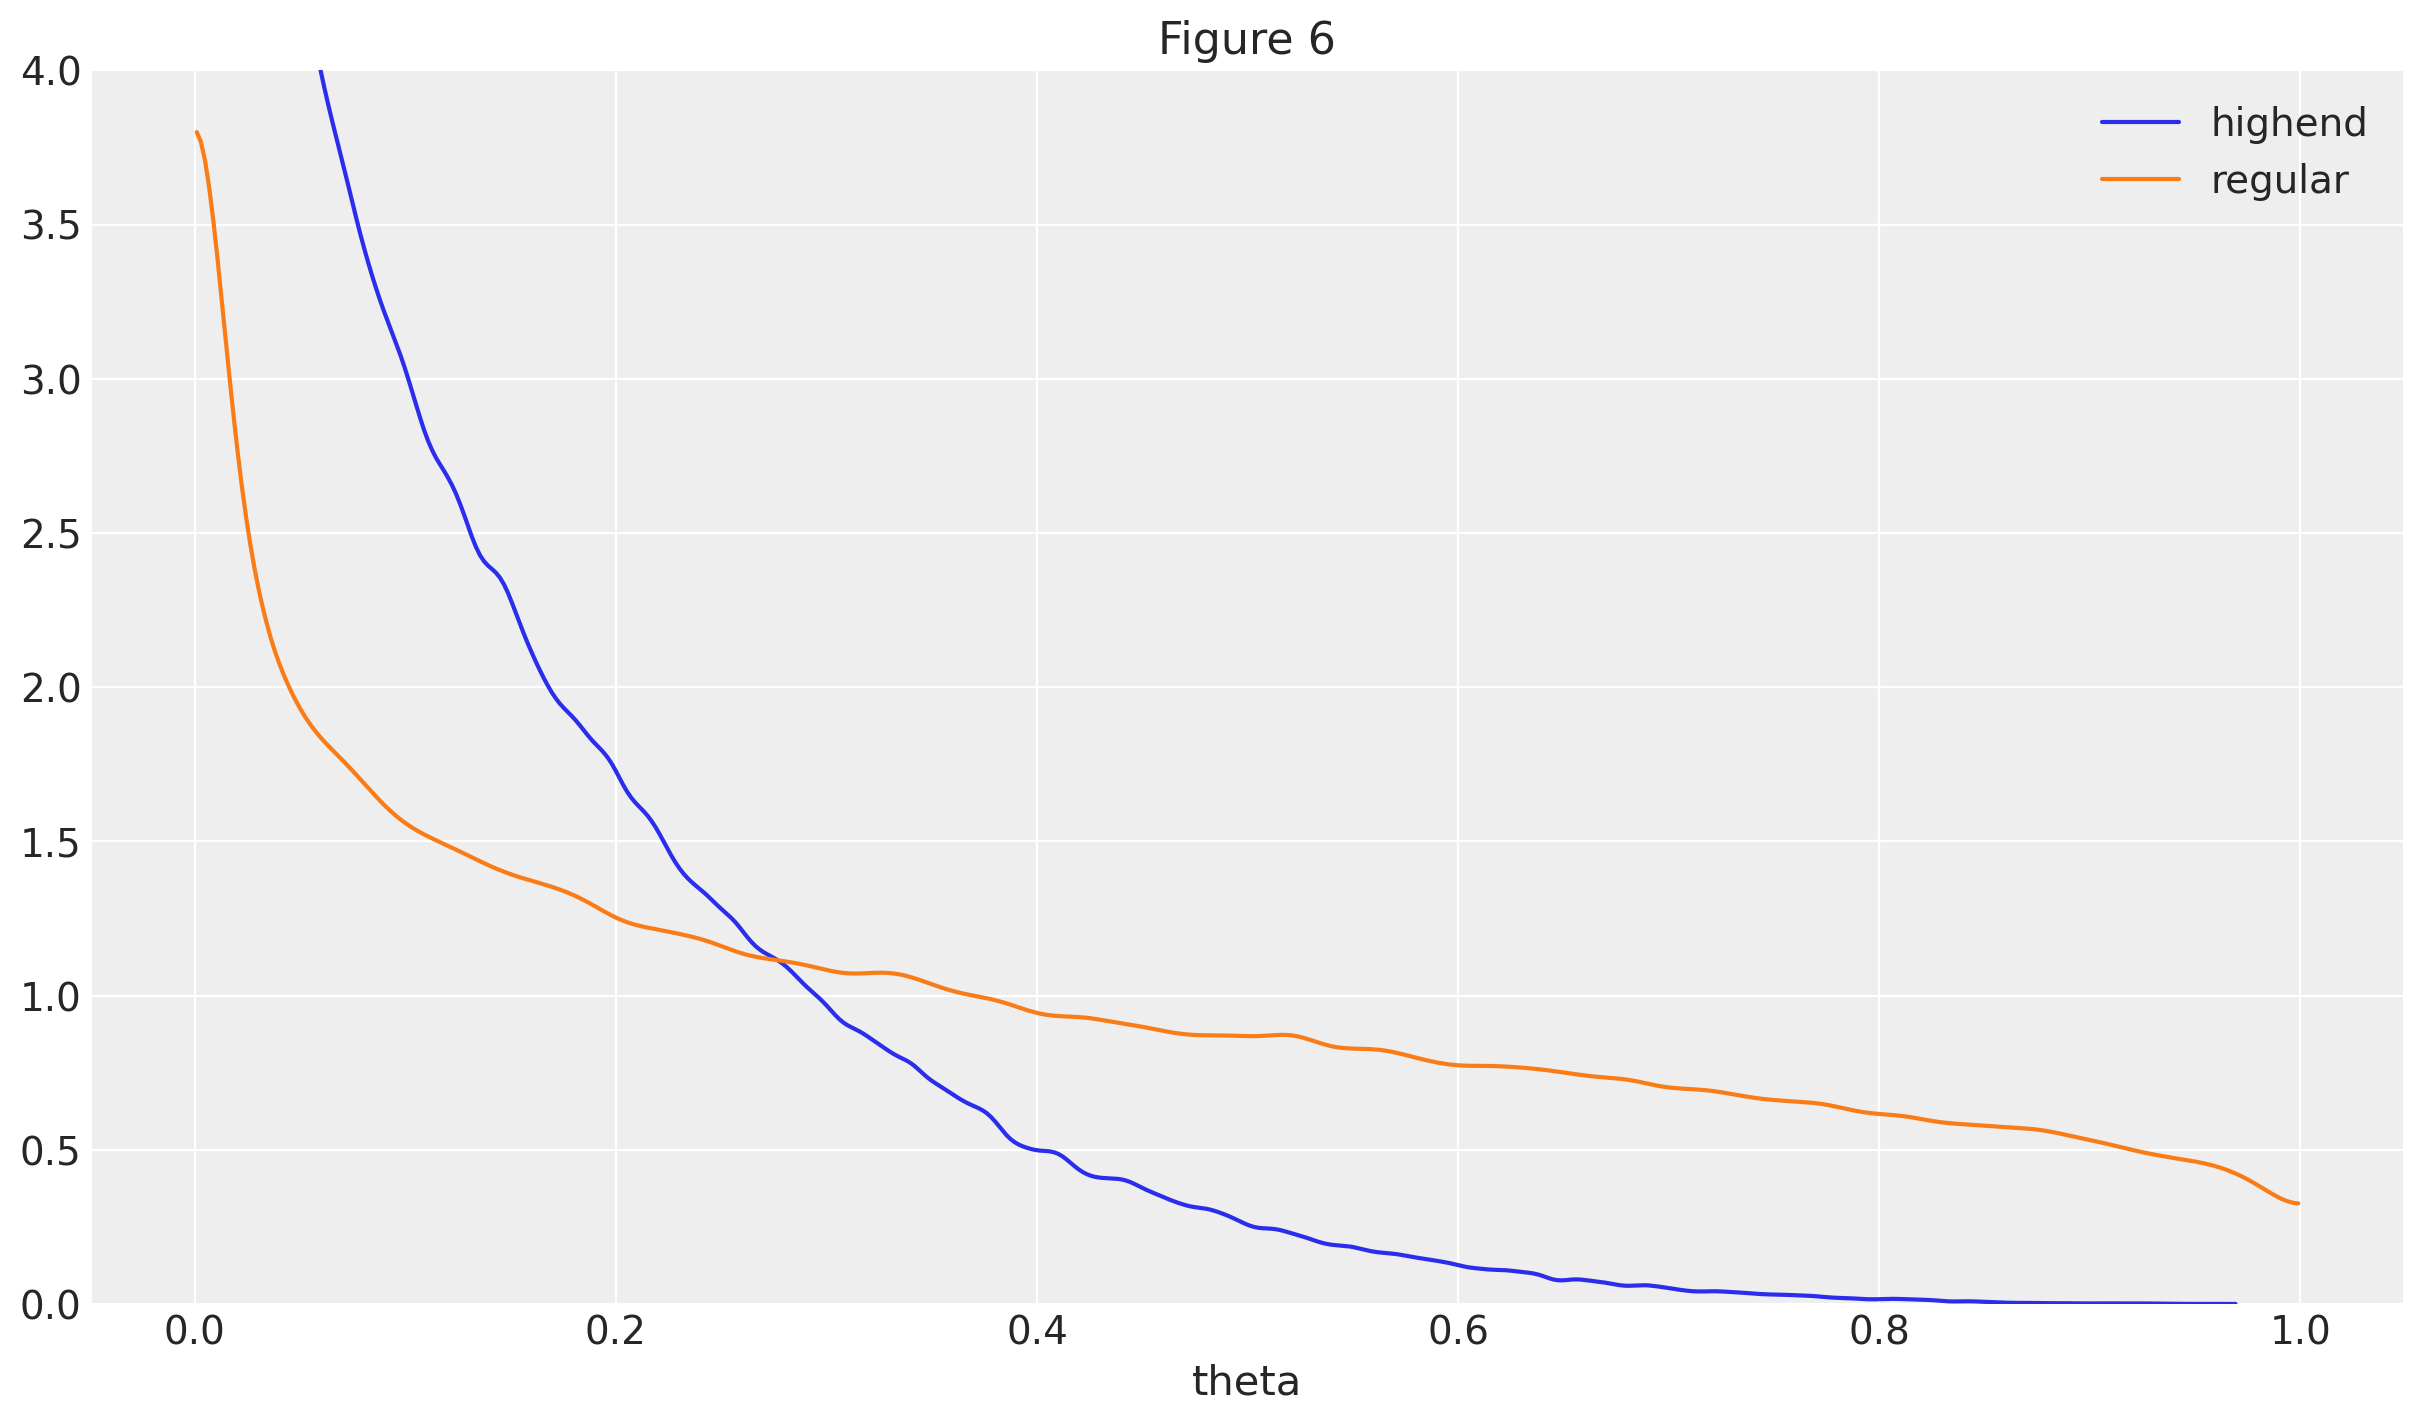

In [19]:
ax = az.plot_dist(new_highend_theta, label="highend")
ax = az.plot_dist(new_regular_theta, label="regular", ax=ax, color="C1")
ax.set_xlabel("theta")
plt.ylim([0, 4])
ax.set_title("Figure 6");

Figures 4 and 5 show the predicted average churn and retention trends for the two groups.
We can see that predictions nicely match the observed data (black line), even when extrapolating into the time periods that were held-out when fitting the model.

The plots also highlight an interesting implication from the model: 
the retention rates are expected to increase over time, as the more precarious customers gradually drop out. This is a direct consequence of modelling individual churn rates as being fixed over time.

In [21]:
weeks = xr.DataArray(np.arange(1, 14), dims=["weeks"])

survival_perc_highend = 100 - 100 * (churn_highend < weeks)
survival_perc_regular = 100 - 100 * (churn_regular < weeks)

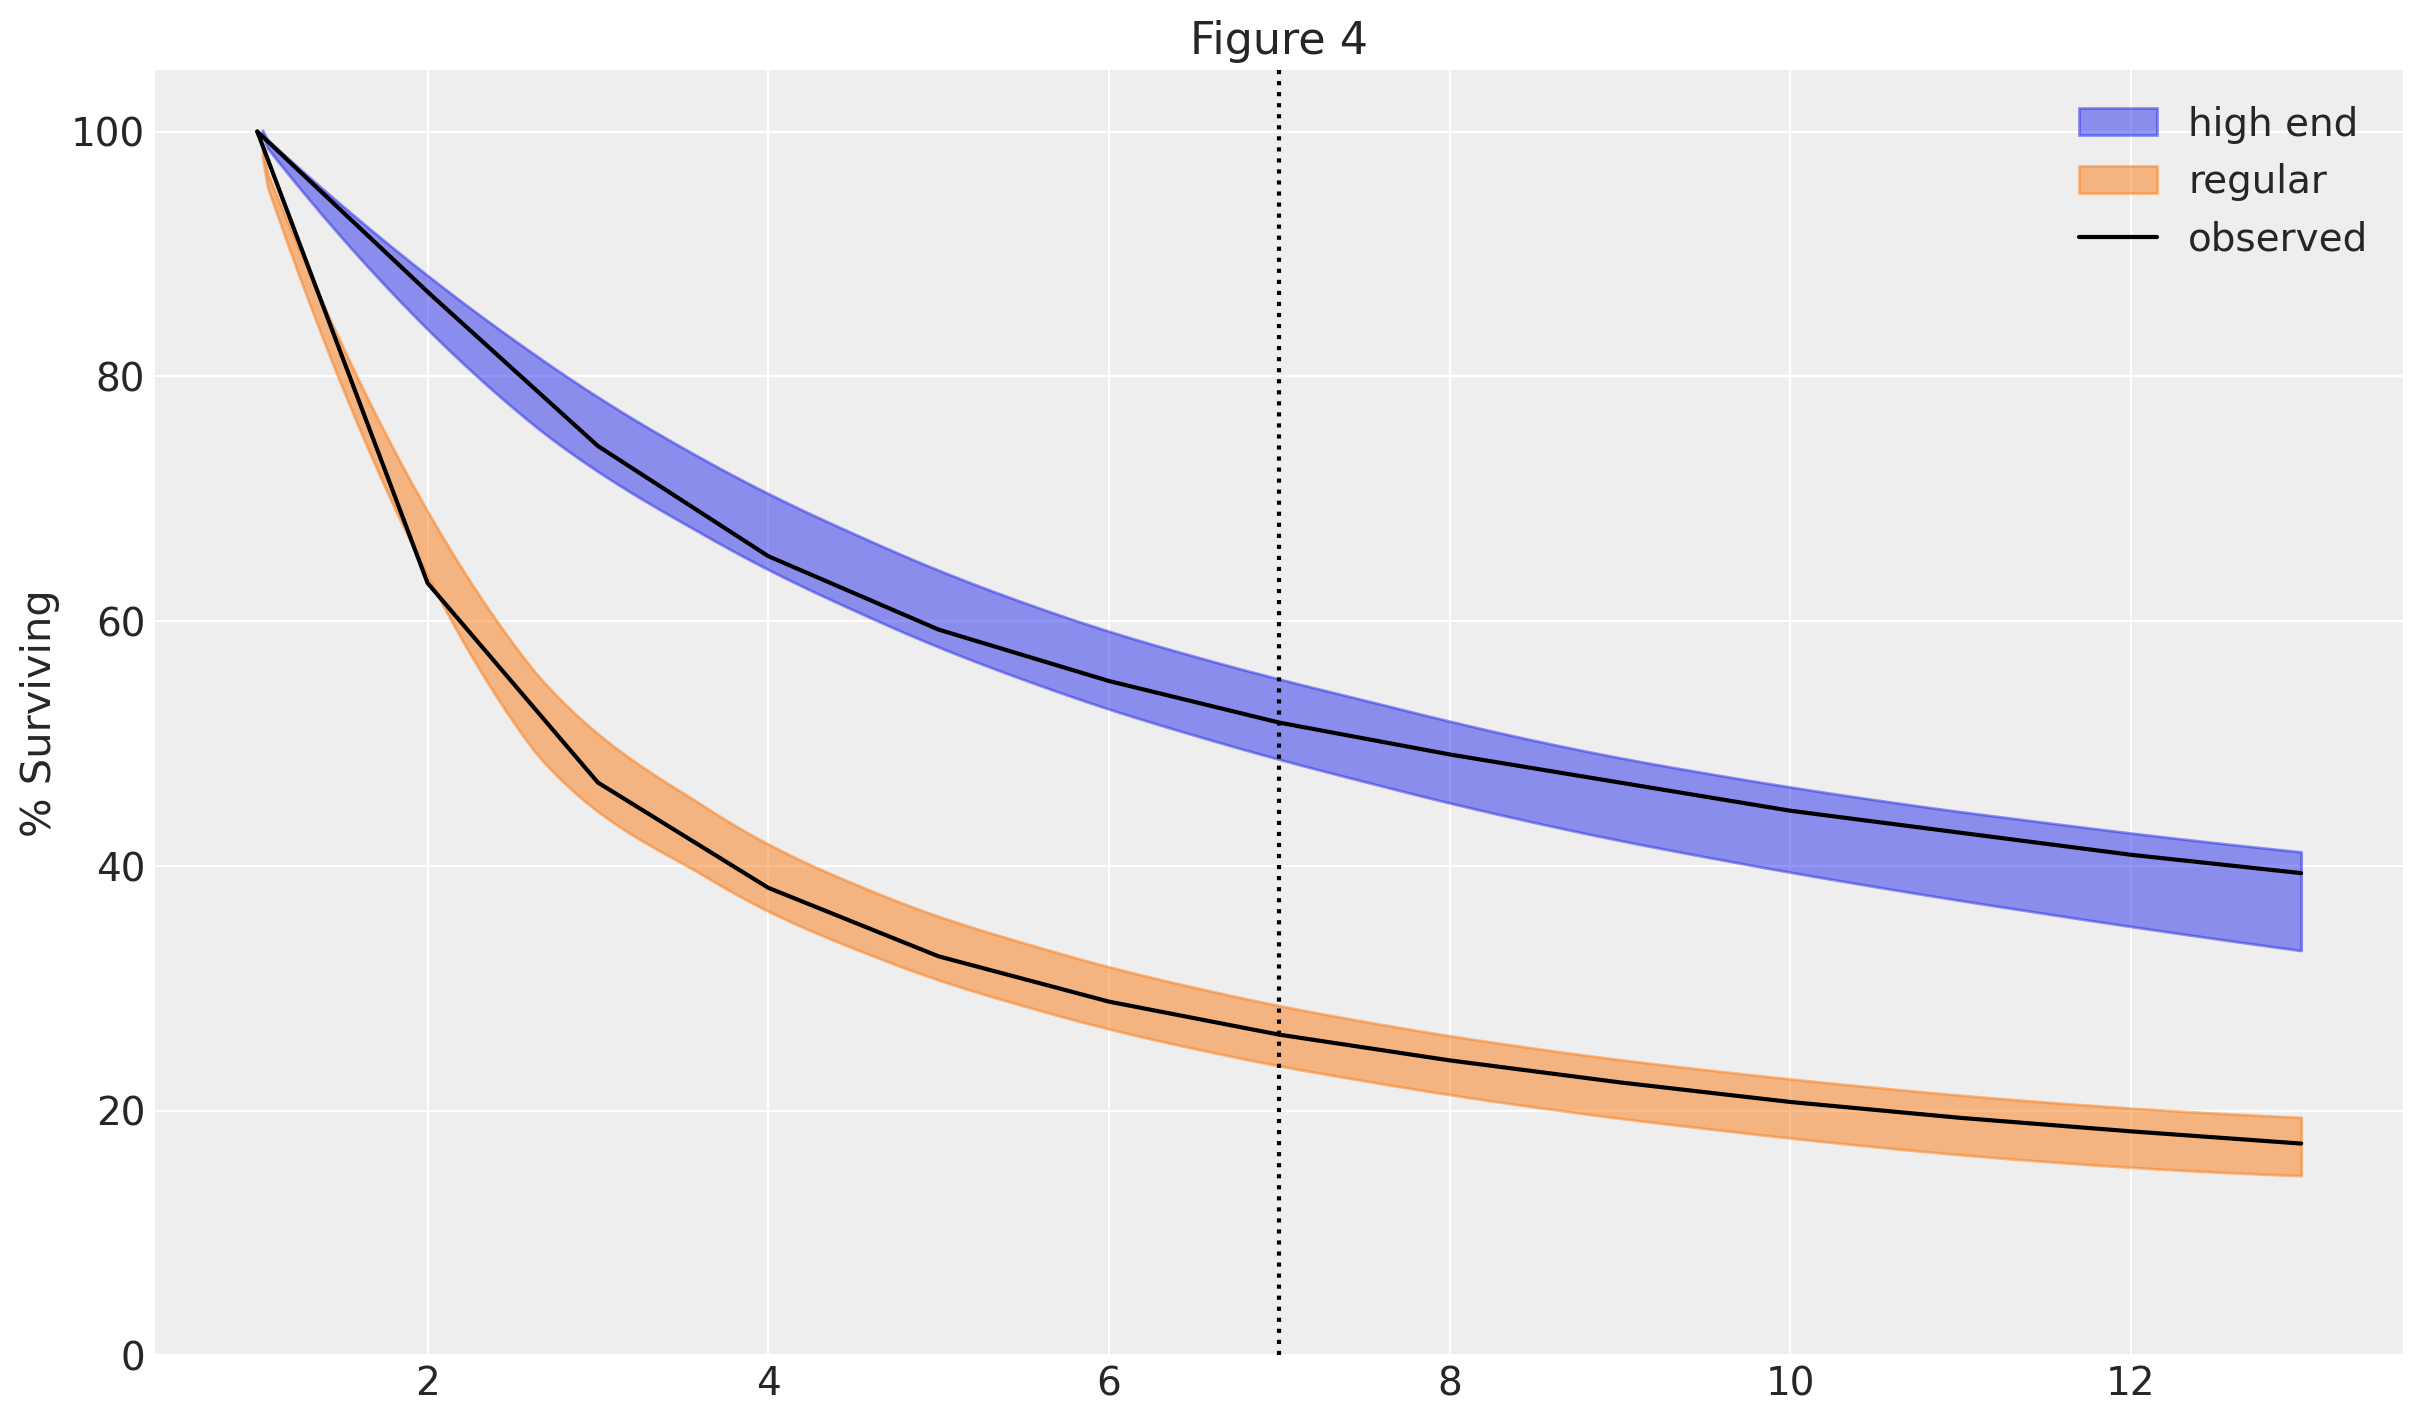

In [22]:
az.plot_hdi(
    weeks,
    survival_perc_highend.mean("customer_id"),
    hdi_prob=0.95,
    color="C0",
    fill_kwargs={"label": "high end"},
)
az.plot_hdi(
    weeks,
    survival_perc_regular.mean("customer_id"),
    hdi_prob=0.95,
    color="C1",
    fill_kwargs={"label": "regular"},
)

plt.plot(weeks, df["highend"], color="k", label="observed")
plt.plot(weeks, df["regular"], color="k")

plt.axvline(7, ls=":", color="k")
plt.ylim([0, 105])
plt.ylabel("% Surviving")
plt.legend()
plt.title("Figure 4");

In [23]:
retention_rate_highend = survival_perc_highend.isel(
    weeks=slice(1, None, None)
) / survival_perc_highend.isel(weeks=slice(None, -1, None))
retention_rate_regular = survival_perc_regular.isel(
    weeks=slice(1, None, None)
) / survival_perc_regular.isel(weeks=slice(None, -1, None))

retention_rate_highend_obs = df["highend"][1:].values / df["highend"][:-1].values
retention_rate_regular_obs = df["regular"][1:].values / df["regular"][:-1].values

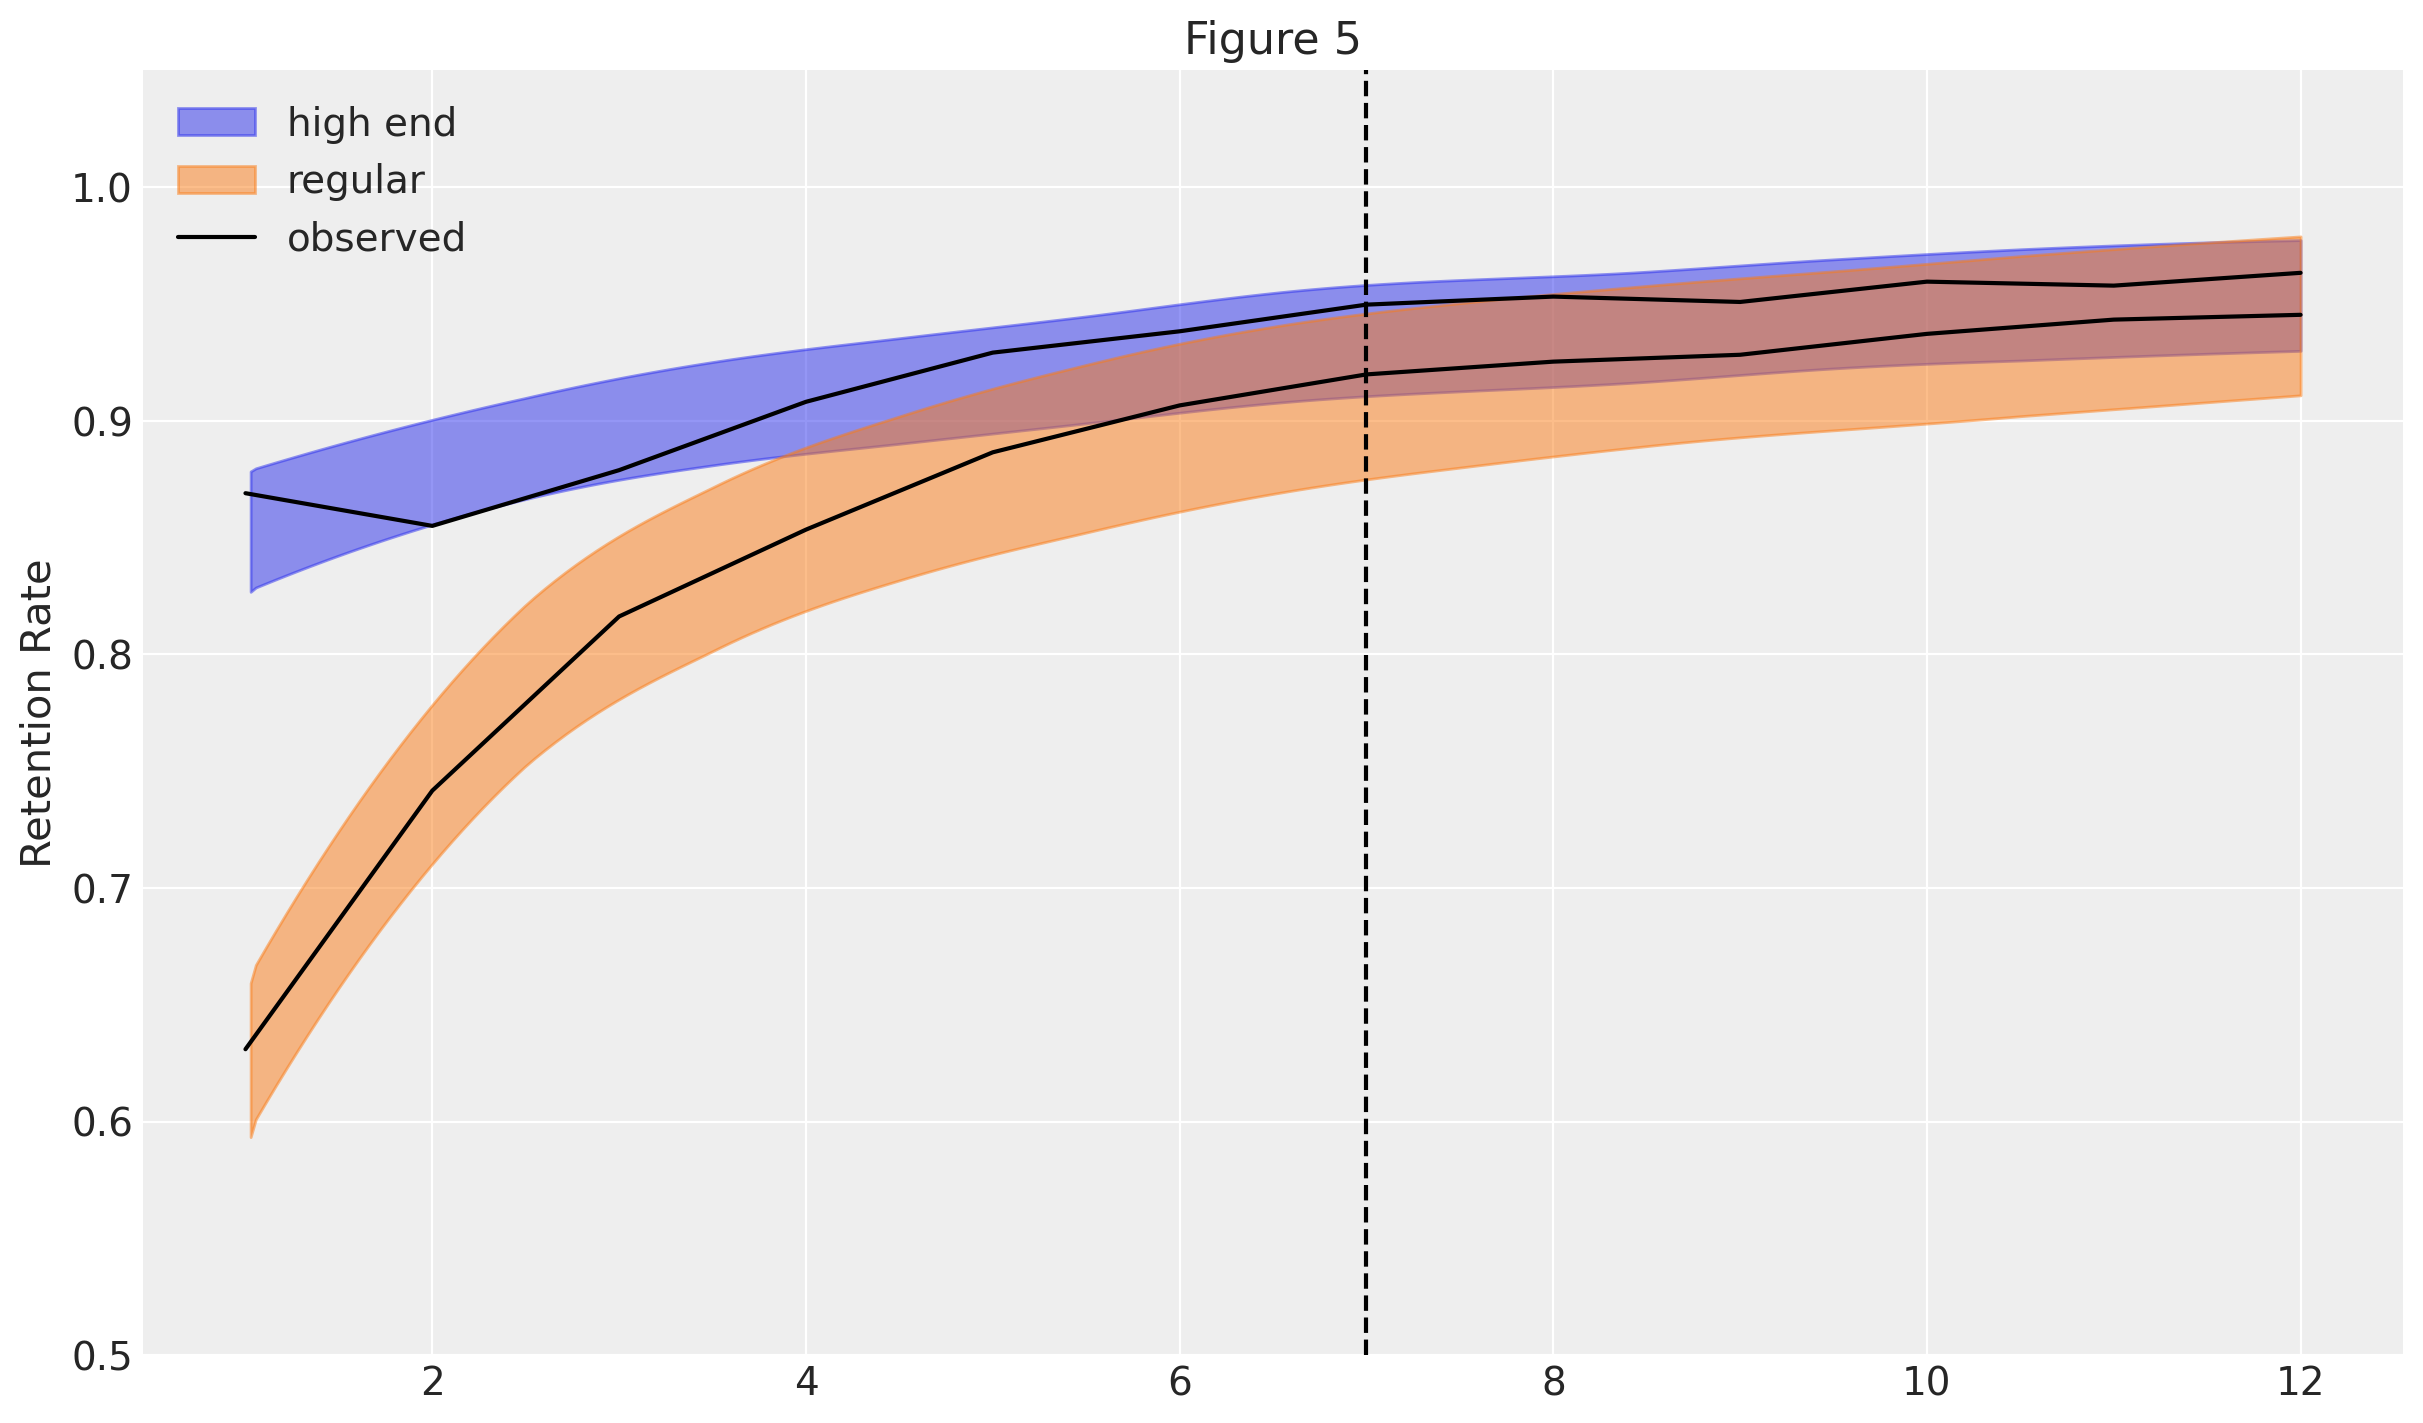

In [24]:
weeks_ = weeks[:-1]

az.plot_hdi(
    weeks_,
    retention_rate_highend.mean("customer_id"),
    hdi_prob=0.95,
    color="C0",
    fill_kwargs={"label": "high end"},
)
az.plot_hdi(
    weeks_,
    retention_rate_regular.mean("customer_id"),
    hdi_prob=0.95,
    color="C1",
    fill_kwargs={"label": "regular"},
)

plt.plot(weeks_, retention_rate_highend_obs, color="k", label="observed")
plt.plot(weeks_, retention_rate_regular_obs, color="k")

plt.axvline(7, ls="--", color="k")
plt.ylim([0.5, 1.05])
plt.ylabel("Retention Rate")
plt.legend()
plt.title("Figure 5");

In [78]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc,pytensor

Last updated: Sun Sep 28 2025

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.4.0

pymc    : 5.25.1
pytensor: 2.31.7

xarray        : 2025.7.1
pymc_marketing: 0.15.1
pymc_extras   : 0.4.0
numpy         : 2.2.6
pandas        : 2.3.1
pytensor      : 2.31.7
matplotlib    : 3.10.3
pymc          : 5.25.1
arviz         : 0.22.0

Watermark: 2.5.0

